In [1]:
sizes = (100, 500, 1000, 5000, 10000, 50000, 100000)   # Размеры баз данных на вход

from dataclasses import dataclass

@dataclass(eq=False)
class Marriage:
    """
    Датакласс, отвечающий за инициализацию объектов типа Marriage.
    Инициализация происходит посредством передачи в конструктор класса параметров ниже.
    """
    groomName: str        # ФИО жениха
    groomBirthday: str    # Дата рождения жениха
    brideName: str        # ФИО невесты
    brideBirthday: str    # Дата рождения невесты
    marriageDate: str     # Дата свадьбы
    registryNumber: str   # Номер ЗАГСа
        
    def __gt__(self, other):
        """
        Перегрузка оператора ">" для сравнения объектов.
        Сравнение идёт сначала по имени жениха, затем по дате свадьбы, затем по номеру ЗАГСа.
        :param other: объект справа от оператора.
        :return: True, если self > other; False - в обратном случае.
        """
        if self.groomName > other.groomName:
            return True
        elif int(self.registryNumber) == int(other.registryNumber):
            if self.marriageDate > other.marriageDate:
                return True
            elif self.marriageDate == other.marriageDate:
                if int(self.registryNumber) > int(other.registryNumber):
                    return True
        return False
        
    def __lt__(self, other):
        """
        Перегрузка оператора "<" для сравнения объектов.
        Сравнение идёт сначала по имени жениха, затем по дате свадьбы, затем по номеру ЗАГСа.
        :param other: объект справа от оператора.
        :return: True, если self < other; False - в обратном случае.
        """
        if self.groomName < other.groomName:
            return True
        elif int(self.registryNumber) == int(other.registryNumber):
            if self.marriageDate < other.marriageDate:
                return True
            elif self.marriageDate == other.marriageDate:
                if int(self.registryNumber) < int(other.registryNumber):
                    return True
        return False
    
    def toStr(self):
        """
        Строковое представление объекта.
        :return: Строка с параметрами конструктора через пробел.
        """
        return ' '.join(self.__dict__.values())

def quickSort(data):
    """
    Алгоритм быстрой сортировки списка.
    :param data: Список объектов типа Marriage.
    :return: Отсортированный список объектов типа Marriage.
    """
    less, pivotList, more = [], [], []
    if len(data) <= 1:
        return data
    else:
        pivot = data[0]
        for i in data:
            if i < pivot:
                less.append(i)
            elif i > pivot:
                more.append(i)
            else:
                pivotList.append(i)
        less = quickSort(less)
        more = quickSort(more)
        return less + pivotList + more

# Предварительная сортировка данных для бинарного поиска
for size in sizes:
    db = open(f'databases/db{size}.txt')
    with open(f'search/sorted{size}.txt', 'w') as file:
        file.writelines(quickSort(db.readlines()))
    db.close()

# Словарь для списков отсортированных данных с указанием размеров
marriagesSorted = {}
for size in sizes:
    with open(f'search/sorted{size}.txt') as db:
        marriagesSorted[size] = [
            Marriage(
                groomName = ' '.join(line[:3]),
                groomBirthday = line[3],
                brideName = ' '.join(line[4:7]),
                brideBirthday = line[7],
                marriageDate = line[8],
                registryNumber = line[9]
            ) for line in map(lambda line: line.split(), db.readlines())
        ]

# Словарь для списков неотсортированных данных с указанием размеров
marriagesUnsorted = {}
for size in sizes:
    with open(f'databases/db{size}.txt') as db:
        marriagesUnsorted[size] = [
            Marriage(
                groomName = ' '.join(line[:3]),
                groomBirthday = line[3],
                brideName = ' '.join(line[4:7]),
                brideBirthday = line[7],
                marriageDate = line[8],
                registryNumber = line[9]
            ) for line in map(lambda line: line.split(), db.readlines())
        ]

def linearSearch(array, query):
    """
    Алгоритм прямого поиска объекта в списке.
    :param array: Список объектов типа Marriage.
    :param query: Строка, содержащая ФИО жениха.
    :return: Список найденных объектов.
    """
    return [element.toStr() for element in array if element.groomName == query]

def binarySearch(array, query):
    """
    Алгоритм бинарного поиска объекта в списке.
    :param array: Список объектов типа Marriage.
    :param query: Строка, содержащая ФИО жениха.
    :return: Список найденных объектов.
    """
    leftBound = 0
    rightBound = len(array) - 1
    middleBound = rightBound // 2
    while array[middleBound].groomName != query and leftBound < rightBound:
        if query > array[middleBound].groomName:
            leftBound = middleBound + 1
        else:
            rightBound = middleBound - 1
        middleBound = (leftBound+rightBound) // 2
    if leftBound > rightBound: 
        return []
    elif leftBound == rightBound:
        return [array[middleBound].toStr()] if array[middleBound].groomName == query else []
    else:
        results = []
        flagLeft, flagRight = True, True
        for i in range(rightBound-middleBound):
            if flagLeft:
                if array[middleBound-i].groomName == query:
                    results.append(array[middleBound-i].toStr())
                else:
                    flagLeft = False
            if flagRight:
                if array[middleBound+i+1].groomName == query:
                    results.append(array[middleBound+i+1].toStr())
                else:
                    flagRight = False
        return results

In [5]:
import numpy as np
from time import time

"""
Выполнение непосредственной задачи - поиск и сравнение скоростей разных его видов.
"""

timing = {'Прямой поиск': [], 'Бинарный поиск': [], 'Сортировка и бинарный поиск': [], 'Поиск по ключу': []}
for size in sizes:
    sortedCopy = marriagesSorted[size].copy()
    
    # Случайно выбираем ФИО жениха для поиска
    randomGroom = sortedCopy[np.random.randint(size)].groomName
    print(f'\nРазмер: {size}.\tИщем:', randomGroom)
    
    # Счётчики времени различных видов поиска (в микросекундах)
    linearTime, binaryTime, keyTime = 0, 0, 0
    
    # Находим среднее время прямого и бинарного поисков по 10000 попыткам
    for _ in range(10000):
        check = time()
        linearSearch(sortedCopy, randomGroom)
        linearTime += time() - check

        check = time()
        binarySearch(sortedCopy, randomGroom)
        binaryTime += time() - check
    
    linearTime *= 1e2
    print('Прямой поиск.\t\t\tВремя (мкс): %.2f' % linearTime)
    print('Результат:', *linearSearch(sortedCopy, randomGroom))
    timing['Прямой поиск'].append(linearTime)
    
    binaryTime *= 1e2
    print('Бинарный поиск.\t\t\tВремя (мкс): %.2f' % binaryTime)
    print('Результат:', *binarySearch(sortedCopy, randomGroom))
    timing['Бинарный поиск'].append(binaryTime)
    
    # Находим время бинарного поиска вместе с сортировкой
    unsortedCopy = marriagesUnsorted[size].copy()
    check = time()
    binarySearch(quickSort(unsortedCopy), randomGroom)
    check = (time() - check) * 1e3
    print('Сортировка и бинарный поиск.\tВремя (мс):  %.2f' % check)
    print('Результат:', *binarySearch(quickSort(unsortedCopy), randomGroom))
    timing['Сортировка и бинарный поиск'].append(check*1e3)
    
    # Словарь для поиска по ключу. 
    # Ключи - ФИО женихов, значения - объекты типа Marriage.    
    from collections import defaultdict
    multimap = defaultdict(list)
    for groomName, marriage in zip(map(lambda obj: obj.groomName, unsortedCopy), unsortedCopy):
        multimap[groomName].append(marriage)
    
    # Находим среднее время поиска по ключу по 50000 попыткам
    for _ in range(50000):
        check = time()
        map(lambda obj: obj.toStr(), multimap[randomGroom])
        keyTime += time() - check
    
    keyTime *= 20
    print('Поиск по ключу.\t\t\tВремя (нс):  %.2f' % (keyTime*1e3))
    print('Результат:', *map(lambda obj: obj.toStr(), multimap[randomGroom]))
    timing['Поиск по ключу'].append(keyTime)


Размер: 100.	Ищем: Карпов Парамон Владленович
Прямой поиск.			Время (мкс): 6.90
Результат: Карпов Парамон Владленович 1987-10-21 Попова Олимпиада Юрьевна 1993-02-28 2020-02-29 538
Бинарный поиск.			Время (мкс): 2.28
Результат: Карпов Парамон Владленович 1987-10-21 Попова Олимпиада Юрьевна 1993-02-28 2020-02-29 538
Сортировка и бинарный поиск.	Время (мс):  1.00
Результат: Карпов Парамон Владленович 1987-10-21 Попова Олимпиада Юрьевна 1993-02-28 2020-02-29 538
Поиск по ключу.			Время (нс):  923.04
Результат: Карпов Парамон Владленович 1987-10-21 Попова Олимпиада Юрьевна 1993-02-28 2020-02-29 538

Размер: 500.	Ищем: Соколов Рюрик Антонович
Прямой поиск.			Время (мкс): 22.78
Результат: Соколов Рюрик Антонович 1984-07-06 Мартынова Вероника Тарасовна 1992-12-05 2020-01-30 535
Бинарный поиск.			Время (мкс): 3.15
Результат: Соколов Рюрик Антонович 1984-07-06 Мартынова Вероника Тарасовна 1992-12-05 2020-01-30 535
Сортировка и бинарный поиск.	Время (мс):  3.00
Результат: Соколов Рюрик Антонович

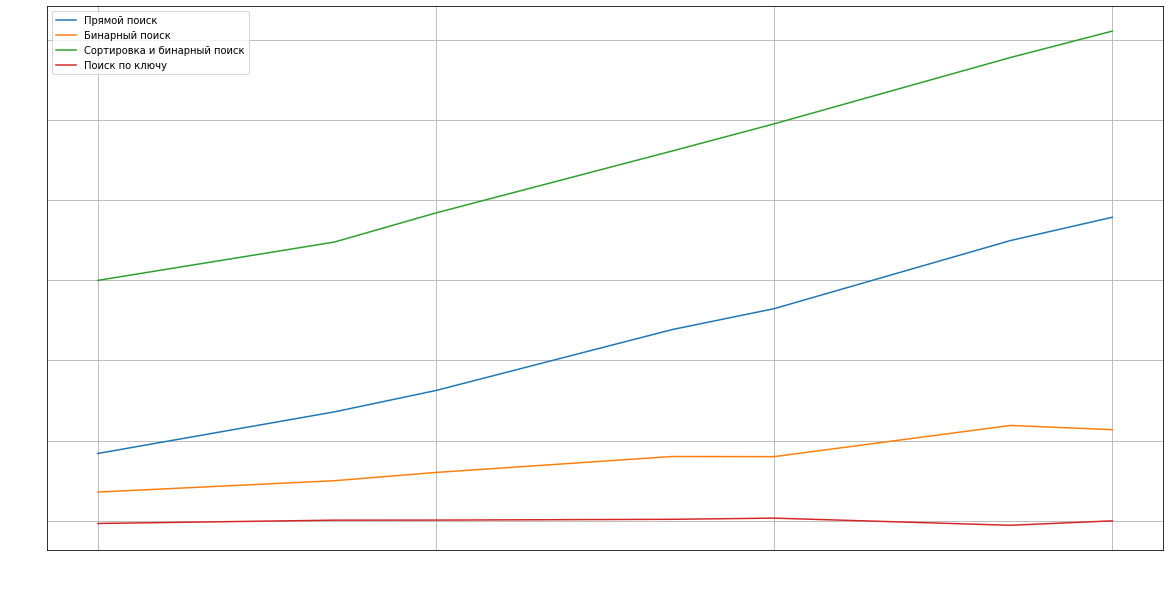

In [6]:
from matplotlib import pyplot as plt
plt.rc(('xtick', 'ytick'), color='white')
plt.figure(figsize=(20, 10))
plt.plot(sizes, timing['Прямой поиск'], label='Прямой поиск')
plt.plot(sizes, timing['Бинарный поиск'], label='Бинарный поиск')
plt.plot(sizes, timing['Сортировка и бинарный поиск'], label='Сортировка и бинарный поиск')
plt.plot(sizes, timing['Поиск по ключу'], label='Поиск по ключу')
plt.grid()
plt.legend()
plt.xlabel('Объём входных данных', color='white')
plt.ylabel('Время поиска, мкс', color='white')
plt.xscale('log')
plt.yscale('log')
plt.savefig('lab2_search_timing.pdf')